# Resample MODIS MOD02 data to EASE-Grid 2.0 North

In this notebook I use `satpy` to resample a MOD02 scene to the EASE-Grid 2.0 North grid and display it.

In [1]:
import os
import glob
import warnings

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from pyresample import geometry
#from pyresample.ewa import ll2cr, fornav

from satpy import Scene
from satpy.writers import get_enhanced_image

I use MOD02HKM (500m resolution) swath data as an example.  The corresponding MOD03 geolocation are required.  These are in separate directories, so I use `glob` to find the MOD02HKM image data and corresponding MOD03 data.  For the example, I load only channels 1, 4 and 3.  These are equivalent to red, green and blue channels.  I also request a true color composite.  This composite cannot be generated from swath data but it is generated automatically when the swath data are resampled.

In [2]:
DATAPATH = '/media/apbarret/stroeve_projects/modis_downloads'
mod02hkm_files = glob.glob(os.path.join(DATAPATH, 'MOD02HKM', '2015', '091', '*2015091.1110.*.hdf'))
geoloc_files = glob.glob(os.path.join(DATAPATH, 'MOD03', '2015', '091', '*2015091.1110.*.hdf'))
scene = Scene(reader='modis_l1b', filenames=mod02hkm_files + geoloc_files)
scene.load(['1', '4', '3', 'true_color'])

The following datasets were not created and may require resampling to be generated: DatasetID(name='true_color', wavelength=None, resolution=None, polarization=None, calibration=None, level=None, modifiers=None)


Next, we define the grid that the swath data are resampled to.  In this case, it is the EASE-Grid 2.0 North projection.  Projection information can be defined by a proj4 string or dictionary of proj4 elements.  The grid resolution is defined by nrows and ncols. In this case `nrows=720*8` is equivalent to ~1.5 km x 1.5 km grid.

In [18]:
area_id = 'ease2_nh'
description = 'EASE-Grid 2.0 North'
grid_id = 'ease2_nh'
projection = '+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs'
nrows = 720*8
ncols = 720*8
extent = [-4500000.0, -4500000.0, 4500000.0, 4500000.0]  # Note this is (x_min, y_min, x_max, y_max)
ease2_def = geometry.AreaDefinition(area_id, description, grid_id,
                                   projection,
                                   nrows, ncols,
                                   extent)

I want to use the same resampling method as used in NSIDC MS2GT swath to grid tool: Elliptical Weighted Averaging.  `satpy` uses `pyresample`, which, in turn, uses `ll2cr` and `fornav` from MS2GT, to perform _EWA_ resampling.

In [19]:
ease_scene = scene.resample(ease2_def, resample='ewa', nprocs=4)

/home/apbarret/anaconda3/envs/satpy/lib/python3.7/site-packages/pyproj/crs/crs.py:539: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
Could not calculate destination definition resolution
Could not calculate destination definition resolution


The results are plotted as a true color composite using `cartopy`.  Before a true color image can be displayed, the true color composite band must be converted to a [PIL image](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.imshow.html).  This is done with the `satpy` `get_enhanced_image` function.  The resulting `PIL.Image.Image` object is displayed using `matplotlib.pyplot.imshow`.  For the plot below, I've set the plot extent to roughly the extent of the original swath data.

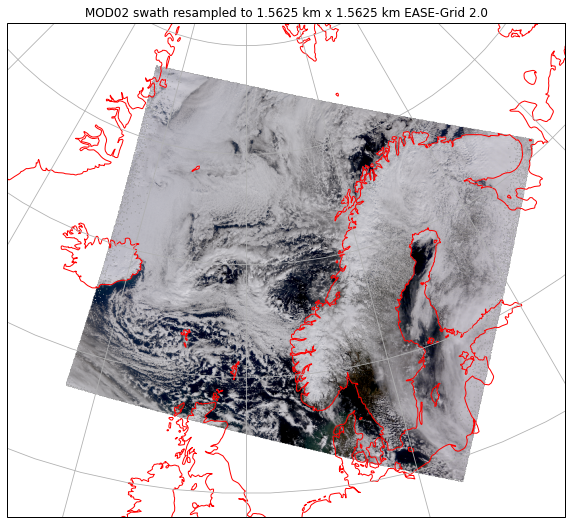

In [20]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    img = get_enhanced_image(ease_scene['true_color']).pil_image()

ease_crs = ease_scene['1'].attrs['area'].to_cartopy_crs()

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=ccrs.NorthPolarStereo())
#ax.set_extent([-180.,180.,30.,90.], ccrs.PlateCarree())
ax.set_extent([-1500000., 2000000., -4300000., -1200000.], ccrs.NorthPolarStereo())
ax.coastlines(resolution='50m', color='red')
ax.imshow(img, origin="upper",
          extent=ease_crs.bounds, transform=ease_crs)
ax.set_title(f'MOD02 swath resampled to {ease2_def.pixel_size_x*10**-3} km x {ease2_def.pixel_size_x*10**-3} km EASE-Grid 2.0')
ax.gridlines()

In [37]:
OUTPUT_DIR = '.'
band_name = '1'
dataset_fout = os.path.basename(mod02hkm_files[0]).replace('HKM',f'.{band_name}.{area_id}.ewa').replace('hdf', 'tif')
print(f'Writing resampled data to {os.path.join(OUTPUT_DIR,dataset_fout)}')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ease_scene.save_datasets(dataset_id=band_name, writer='geotiff', filename=dataset_fout, base_dir=OUTPUT_DIR)

Writing resampled data to ./MOD02.1.ease2_nh.ewa.A2015091.1110.061.2017320013156.tif
